# Анализ вакансий в канале #_jobs в слаке Open Data Science

## Вступление

Рынок труда в области Data Science стремительно рос последние 5 лет. Вместе с тем, как все больше компаний используют у себя анализ больших данных, все больше появляется курсов для подготовки специалистов по анализу данных и, соответственно, их слушателей.

Поэтому интересно было, как со временем менялась зарплата и какие есть тренды. Вакансии можно посмотреть, например, в канале #_jobs в слаке сообщества Open Data Science. Это и будет набором данных для анализа.

## Инструменты анализа

Данные изначально были представлены в виде постов в канале Слак. Я использовал утилиту [ParseHub](parsehub.com) и библиотеки Питона `BeautifulSoup` и `Selenium` для того, чтобы спарсить все посты. На выходе получался Pandas датафрейм с колонками ссылок на сообщение, автора, текста сообщения и даты и времени сообщения. Также был проведен предварительный анализ сообщений: все сообщения, не содержащие цифры, были убраны из рассмотрения из соображения, что пост с вакансией имеет цифровую запись предлагаемой зарплаты.

Получилось порядка 2400 сообщений, которые нужно было проверить на то, что они действительно являются вакансиями и содержат вилку. Для этого был предпринят следующий подход: 
1. разметка сообщений по ключевым словам; 
1. обучение алгоритма машинного обучения по размеченным данным для определения того, является ли сообщение вакансией и является ли строка сообщения строкой с вилкой; 
1. применение алгоритма ко всем данным.

По ключевым сообщениям были определены 797 сообщений, затем после ручной проверки была составлена обучающая выборка из 100 постов с вакансиями и 100 постов без вакансий. В качестве алгоритма машинного обучения был использован `CatBoostClassifier` из библиотеки `catboost`. На вход алгоритм получал датафрейм из 7 признаков сообщений (длина сообщения, количество слов, количество строк, количество цифр, количество слов длины 1, количество слов длины 2, количество специальных символов), и он должен определять вероятность события, является ли данное сообщение вакансией или нет. Целевой функцией была кросс-энтропия, в обучении использовалась кросс-валидация. Затем аналогичный алгоритм был составлен для получения вероятности события нахождения вилки в строке с небольшим изменением входных параметров (количество строк заменялось на номер строки и добавлялась вероятность сообщения быть вакансией). При обучении обоих алгоритмов при стандартных параметрах получились значения метрики `roc_auc` 0.92.

При применении алгоритма количество сообщений увеличилось до 929, и из них были выделены значения вилок. К сожалению, всех их пока не представляется возможным проанализировать, так как это вакансии в разных валютах и с удельной зарплатой за разные промежутки времени. Поэтому эти 929 сообщений были отфильтрованы по тому диапазону, где находится вилка, и по запрещенным ключевым словам, чтобы получить сообщения с вакансиями с зарплатой в рублях за месяц (534 сообщения).

In [151]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

In [ ]:
# Getting information for Russian Rubles salaries

In [10]:
with open("user_messages_recognized.json",'r') as fin:
    vacancy_df = pd.read_json(fin)

In [18]:
def check_russian_per_month(msg):
    
    non_russian_words = ["EUR","USD","€","$","ДОЛЛАР","ЕВРО", "UAH", "AED", "BYN", "CAD", "MYR","YEARLY"]
    
    time_words = ["В ГОД", "/ЧАС", "/Ч."]
    
    for word in non_russian_words:
        if word in msg.upper():
            return False
    return True

In [35]:
mask = (((vacancy_df['low_fork'] % 1000 > 10) & 
        (vacancy_df['up_fork'] % 1000 < 700)) &
        (vacancy_df['message'].apply(check_russian_per_month)))

In [ ]:
rus_vacancy_df = vacancy_df[mask]
rus_vacancy_df['low_fork'] = rus_vacancy_df['low_fork'].apply(lambda x: x % 1000)
rus_vacancy_df['up_fork'] = rus_vacancy_df['up_fork'].apply(lambda x: x % 1000)

In [ ]:
# Plotting

In [ ]:
rus_vacancy_df['month'] = rus_vacancy_df['date'].apply(lambda x: x.month)
rus_vacancy_df['year'] = rus_vacancy_df['date'].apply(lambda x: x.year)

In [ ]:
rus_vacancy_df.drop(rus_vacancy_df[rus_vacancy_df['low_fork'] > rus_vacancy_df['up_fork']].index, inplace=True)

## Результаты анализа

Итак, были рассмотрены 534 сообщения с вакансиями с апреля 2015 года по май 2019 года, а именно были посчитаны графики минимальных, максимальных и средних значений за месяц, и количество вакансий в месяц.

Количество вакансий постепенно растет последние 2 года и составляет порядка 20 вакансий в месяц. Пока непонятно, для каких позиций преоладают вакансии.

Средняя вилка для джуниоров составляет 50-120 тысяч рублей в месяц, для мидла — 100-170 т.р., для сеньора — 150-330 т.р. Средняя вилка вообще равна 145-170 т.р.

Также были построены по данным линейные тренд средней зарплаты. Коэффициенты в трендах составляют -1.6 т.р./год для джуниоров, 8.4 т.р./год для мидлов, 6.6 т.р./год для сеньоров и в среднем 6.7 т.р./год.

Рис. 1 Карта вилок (чем ярче, тем позже опубликована вакансия)

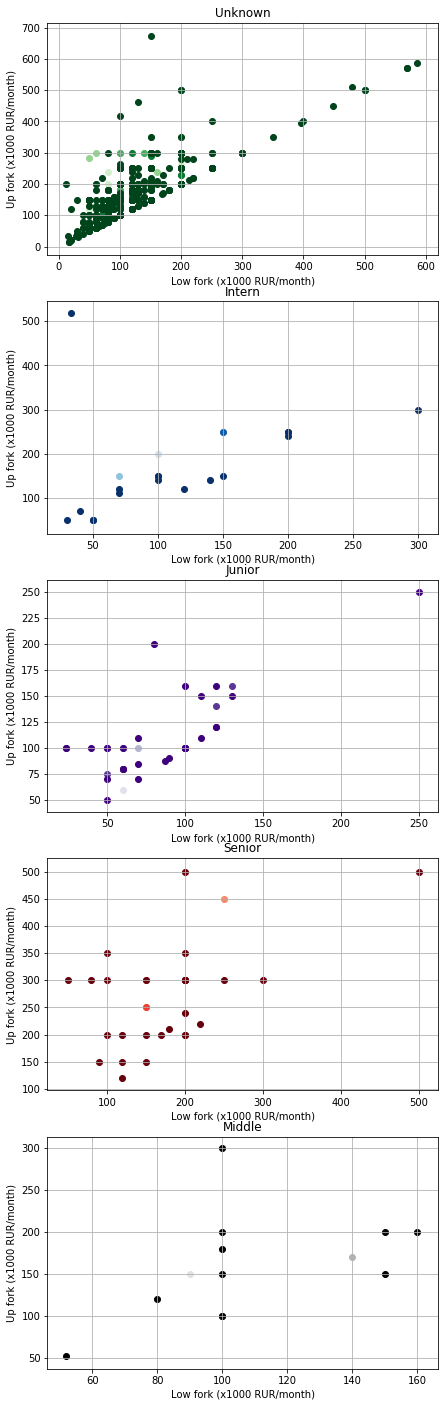

In [107]:
fig, ax = plt.subplots(figsize=(7,35))

cmap_list = ['Greens',
             'Blues',
             'Purples',
             'Reds',
             'Greys'] 

for j, position in enumerate(rus_vacancy_df.position.unique()):
    plt.subplot(7, 1, j+1)
    for i, year in enumerate(rus_vacancy_df.year.unique()):
        for month in range(12):
            mask = ((rus_vacancy_df['year'] == year) & (rus_vacancy_df['month'] == month + 1))
        #for j, position in enumerate(rus_vacancy_df.position.unique()):
            mask = mask & (rus_vacancy_df['position'] == position)
            X = rus_vacancy_df[mask].low_fork
            Y = rus_vacancy_df[mask].up_fork
            cmap = plt.cm.get_cmap(cmap_list[j])
            color = cmap(0.5*(i*12+month)/12*len(rus_vacancy_df.year.unique())+0.2)
            plt.scatter(X,Y, c=[color])
    
    plt.xlabel('Low fork (x1000 RUR/month)')
    plt.ylabel('Up fork (x1000 RUR/month)')
    plt.title(position)
    plt.grid(True)
        

plt.show()

In [108]:
rus_vacancy_df_plot = rus_vacancy_df.groupby(['year', 'month', 'position'])

In [230]:
class my_date(str):
    def __lt__(a,b):
        date_a = a.split('/')
        date_b = b.split('/')
        if (int(date_a[1]) == int(date_b[1])):
            return (int(date_a[0]) < int(date_b[0]))
        return (int(date_a[1]) < int(date_b[1]))
    def __gt__(a,b):        
        date_a = a.split('/')
        date_b = b.split('/')
        if (int(date_a[1]) == int(date_b[1])):
            return (int(date_a[0]) > int(date_b[0]))
        return (int(date_a[1]) > int(date_b[1]))

Рис. 2 Количество вакансий в месяц

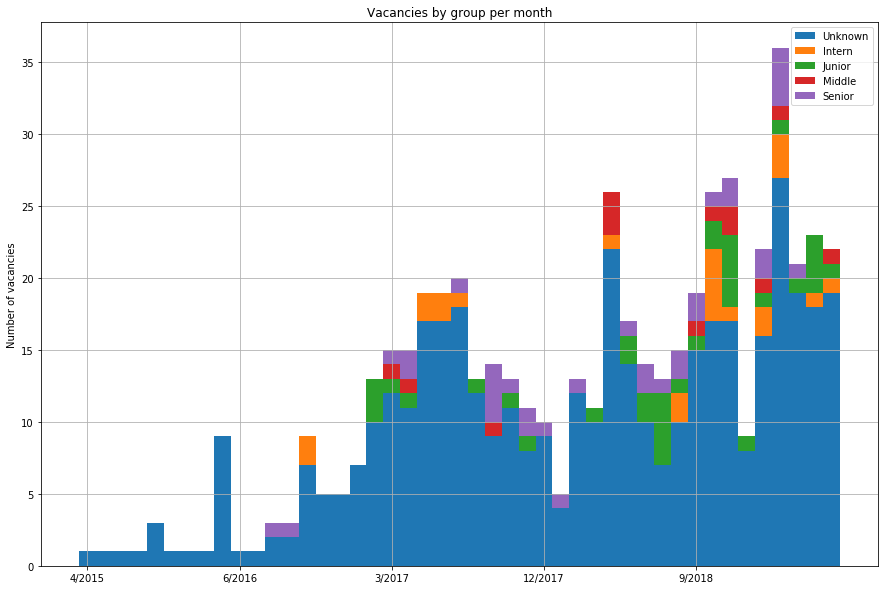

In [233]:
months = sorted(list(set([my_date(str(name[1]) + '/' + str(name[0])) for name, group in rus_vacancy_df_plot])))

positions = list(set([str(name[2]) for name, group in rus_vacancy_df_plot]))

X = np.arange(len(months))

vacancies_amount = {position:np.zeros(len(months)) for position in positions}

date = months[0].split('/')

for i, month in enumerate(months):
    for position in positions:
        date = month.split('/')
        if (int(date[1]),int(date[0]),position) in rus_vacancy_df_plot.groups:
            vacancies_amount[position][i] = rus_vacancy_df_plot.low_fork.size().loc[(int(date[1]),int(date[0]),position)]

unknownVacancies = vacancies_amount["Unknown"]
internVacancies = vacancies_amount["Intern"]
juniorVacancies = vacancies_amount["Junior"]
middleVacancies = vacancies_amount["Middle"]
seniorVacancies = vacancies_amount["Senior"]
#unknownVacancies = np.array(rus_vacancy_df_plot.low_fork.size().loc[:,:,"Unknown"])
#internVacancies = np.array(rus_vacancy_df_plot.low_fork.size().loc[:,:,"Intern"])
#juniorVacancies = np.array(rus_vacancy_df_plot.low_fork.size().loc[:,:,"Junior"])
#middleVacancies = np.array(rus_vacancy_df_plot.low_fork.size().loc[:,:,"Middle"])
#seniorVacancies = np.array(rus_vacancy_df_plot.low_fork.size().loc[:,:,"Senior"])

fig = plt.figure(figsize=(15,10))

width = 1

p1 = plt.bar(X, unknownVacancies, width)
p2 = plt.bar(X, internVacancies, width, bottom=unknownVacancies)
p3 = plt.bar(X, juniorVacancies, width, bottom=unknownVacancies+internVacancies)
p4 = plt.bar(X, middleVacancies, width, bottom=unknownVacancies+internVacancies+juniorVacancies)
p5 = plt.bar(X, seniorVacancies, width, bottom=unknownVacancies+internVacancies+juniorVacancies+middleVacancies)

plt.title('Vacancies by group per month')
plt.ylabel('Number of vacancies')
plt.xticks(X[::9], months[::9])
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0]),("Unknown","Intern","Junior","Middle","Senior"))
plt.grid(True)

plt.show()

Рис. 3 Средние зарплаты по месяцам

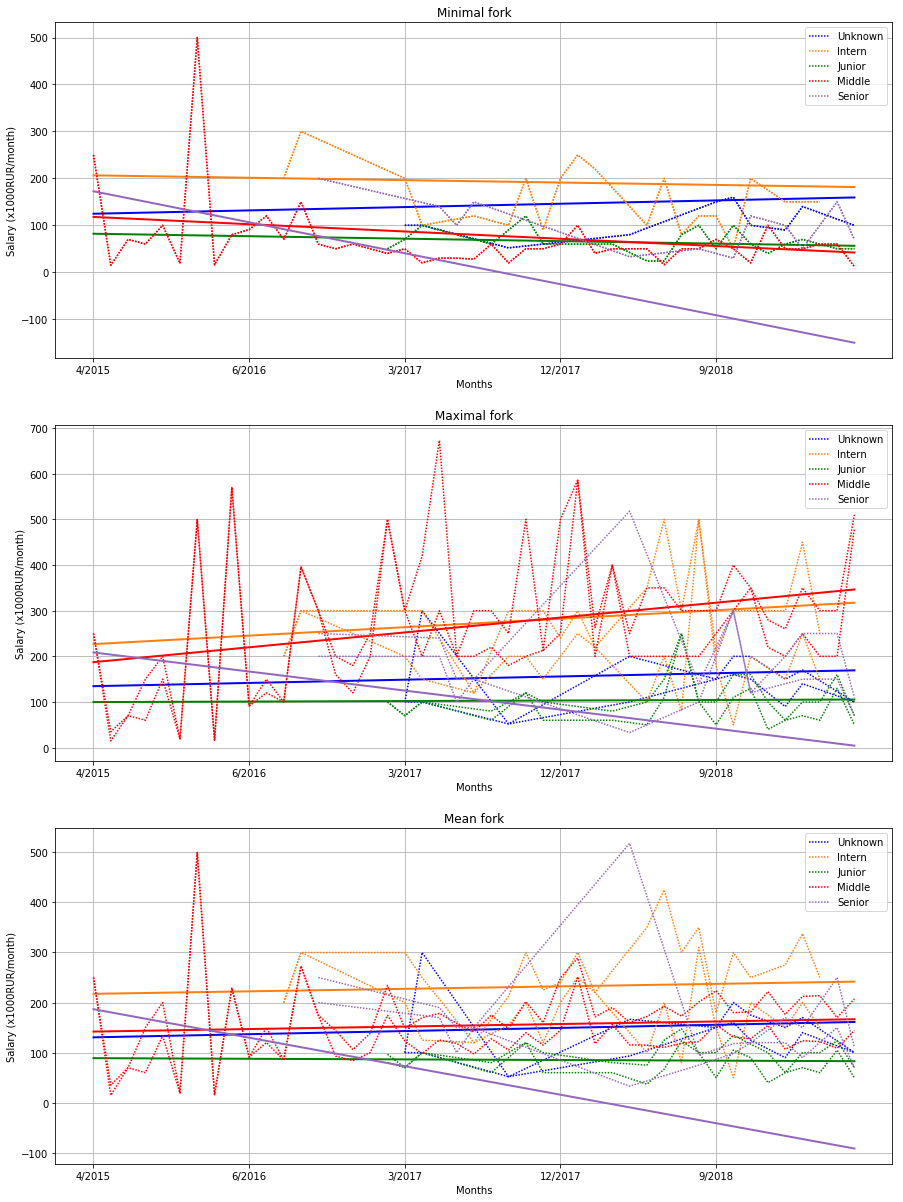

In [234]:
months = sorted(list(set([my_date(str(name[1]) + '/' + str(name[0])) for name, group in rus_vacancy_df_plot])))

positions = list(set([str(name[2]) for name, group in rus_vacancy_df_plot]))

color = ['b','tab:orange','g','r','tab:purple']

fig, ax = plt.subplots(figsize=(15,21))

plt.subplot(3, 1, 1)

p = list()

for j, position in enumerate(positions):
    X = list(range(len(months)))
    Y1 = rus_vacancy_df_plot.low_fork.min().loc[:,:,position]
    Y2 = rus_vacancy_df_plot.up_fork.min().loc[:,:,position]
    for i, month in enumerate(months):
        date = month.split('/')
        if (int(date[1]),int(date[0]),position) not in rus_vacancy_df_plot.groups:
            X.remove(i)
    X = np.array(X)
    p.append(plt.plot(X,Y1, dashes=[1,1], c=color[j]))
    plt.plot(X,Y1, dashes=[1,1], c=color[j])
    coefficients, residuals, _, _, _ = np.polyfit(range(len(Y1.index)),(Y1 + Y2)/2,1,full=True)
    plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(months))], linewidth=2, c=color[j],label=coefficients[0])
    
plt.xlabel('Months')
X = range(len(months))
plt.xticks(X[::9], months[::9])
plt.ylabel('Salary (x1000RUR/month)')
plt.title('Minimal fork')
plt.grid(True)
        
plt.legend((p[0][0],p[1][0],p[2][0],p[3][0],p[4][0]),("Unknown","Intern","Junior","Middle","Senior"))

plt.subplot(3, 1, 2)

p = list()

for j, position in enumerate(positions):
    X = list(range(len(months)))
    Y1 = rus_vacancy_df_plot.low_fork.max().loc[:,:,position]
    Y2 = rus_vacancy_df_plot.up_fork.max().loc[:,:,position]
    for i, month in enumerate(months):
        date = month.split('/')
        if (int(date[1]),int(date[0]),position) not in rus_vacancy_df_plot.groups:
            X.remove(i)
    X = np.array(X)
    p.append(plt.plot(X,Y1, dashes=[1,1], c=color[j]))
    plt.plot(X,Y2, dashes=[1,1], c=color[j])
    coefficients, residuals, _, _, _ = np.polyfit(range(len(Y1.index)),(Y1 + Y2)/2,1,full=True)
    plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(months))], linewidth=2, c=color[j], label=coefficients[0])
    
plt.xlabel('Months')
X = range(len(months))
plt.xticks(X[::9], months[::9])
plt.ylabel('Salary (x1000RUR/month)')
plt.title('Maximal fork')
plt.grid(True)
        
plt.legend((p[0][0],p[1][0],p[2][0],p[3][0],p[4][0]),("Unknown","Intern","Junior","Middle","Senior"))

plt.subplot(3, 1, 3)

p = list()

for j, position in enumerate(positions):
    X = list(range(len(months)))
    Y1 = rus_vacancy_df_plot.low_fork.mean().loc[:,:,position]
    Y2 = rus_vacancy_df_plot.up_fork.mean().loc[:,:,position]
    for i, month in enumerate(months):
        date = month.split('/')
        if (int(date[1]),int(date[0]),position) not in rus_vacancy_df_plot.groups:
            X.remove(i)
    X = np.array(X)
    p.append(plt.plot(X,Y1, dashes=[1,1], c=color[j]))
    plt.plot(X,Y2, dashes=[1,1], c=color[j])
    coefficients, residuals, _, _, _ = np.polyfit(range(len(Y1.index)),(Y1 + Y2)/2,1,full=True)
    plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(months))], linewidth=2, c=color[j], label = coefficients[0])
    
plt.xlabel('Months')
X = range(len(months))
plt.xticks(X[::9], months[::9])
plt.ylabel('Salary (x1000RUR/month)')
plt.title('Mean fork')
plt.grid(True)
        
plt.legend((p[0][0],p[1][0],p[2][0],p[3][0],p[4][0]),("Unknown","Intern","Junior","Middle","Senior"))

plt.show()

## Выводы

Анализ был проведен по вакансиям российских компаний, так что он отражает ситуацию преимущественно на российском рынке специалистов в Data Science. 

Явно видно, что количество требуемых специалистов увеличивается, и в среднем зарплаты увеличиваются, однако этот рост, можно сказать, только покрывает инфляцию (инфляция в 2018 году составила 4.2%, и отношение роста средней зарплате к средней зарплате сейчас составляет те же самые 4.2%). Только для позиции джуниоров наблюдается спад средней зарплаты.

Набор данных оказался довольно информативным относительно зарплат, однако пока не хватает разделения по позициям. Возможно, эту информацию можно почерпнуть из данных с помощь дополнительных алгоритмов. В наборе данных содержится информация про вакансии за рубежом, которую также можно добавить в анализ, так как рынок труда в Data Science доволльно сильно глобализован.